In [20]:
import pandas as pd
import harboropt_lp_valueNewMethod
from ortools.linear_solver import pywraplp
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tnrange
import seaborn as sns
%reload_ext autoreload
%autoreload 2

In [21]:
today_date = '3_5_22'

### Set up input data

In [22]:
#Set up Harbor demand profile.
demand_hour_start = 0
demand_length_hours = 8760
demand = pd.read_csv('data/harbor_hourly_gen_emissions_2019.csv')
demand = demand.fillna(0)
demand = demand[demand_hour_start:demand_hour_start+demand_length_hours]

In [23]:
#Set up hourly max limit for excess energy.
hourly_max_excess_energy = pd.read_csv('data/ladwp_hourly_gen_downscaled.csv')
hourly_max_excess_energy.rename(columns={'Total_Generation_(MWh)':'max_excess_energy (mwh)'},inplace=True)
hourly_max_excess_energy['max_excess_energy (mwh)'] = hourly_max_excess_energy['max_excess_energy (mwh)']-demand['load_mw']
negative_inds = hourly_max_excess_energy['max_excess_energy (mwh)']<0
hourly_max_excess_energy.loc[negative_inds, 'max_excess_energy (mwh)']=0

In [24]:
#Set up CAISO LMP hourly data.
caiso_lmp = pd.read_csv('data/caiso_lmp_ladwp.csv')
caiso_lmp.rename(columns={'MW':'LMP_$/MWh'}, inplace=True)

In [25]:
#Set up marginal grid health damage rates.
ladwp_marginal_healthdamages = pd.read_csv('data/WattTime_MOER/LDWP_healthdamage_moer.csv')
index_list = ladwp_marginal_healthdamages[ladwp_marginal_healthdamages['healthdamage_moer'].isna()].index.tolist()
for index in index_list:
    previous_index = index-1
    ladwp_marginal_healthdamages.loc[index, 'healthdamage_moer']= ladwp_marginal_healthdamages.loc[previous_index, 'healthdamage_moer']
    
#ladwp_marginal_healthdamages['healthdamage_moer']=0

if (ladwp_marginal_healthdamages['healthdamage_moer'].isna()).sum()>0:
    print('Nan values in LADWP marginal healthdamages file.')

In [26]:
#Set up marginal grid CO2 emission rates.
ladwp_marginal_co2 = pd.read_csv('data/WattTime_MOER/LDWP_MOERv3_CO2_2019.csv')
ladwp_marginal_co2['date'] = pd.to_datetime(ladwp_marginal_co2['timestamp_utc']).dt.date
ladwp_marginal_co2['hour'] = pd.to_datetime(ladwp_marginal_co2['timestamp_utc']).dt.hour
ladwp_marginal_co2 = ladwp_marginal_co2.groupby(['date','hour']).mean(['moer (lbs CO2/MWh)']).reset_index()
#ladwp_marginal_co2['moer (lbs CO2/MWh)']=0

In [27]:
#Set up generation profiles for nondispatchable resources. 
#Fix residential lighting generation profiles (fill in missing summer values with winter values).

gen_profiles = pd.read_csv('data/gen_profiles.csv')
lighting_cols = [col for col in gen_profiles.columns if 'ResLighting' in col]
for col in lighting_cols:
    daily_cycle = gen_profiles[col][:24]
    repeats = 7296/24
    daily_cycle_repeat = pd.concat([daily_cycle] * int(repeats), ignore_index=True)
    new_column = pd.concat([daily_cycle_repeat, gen_profiles[col][7296:]],ignore_index=True)
    gen_profiles[col] = new_column

In [28]:
#Set up EE measure list and EE resource potential data.

## Note: The following list of measures make up 95% of the total resource potential across EE measures in 2030, and make up 86% of the annual potential savings across EE measures in 2030. 
ee_measures = pd.read_csv('data/ee_measure_list_reduced.csv')
ee_measure_list_REDUCED = ee_measures['Resource'].unique()

ee_resource_potential = pd.read_csv('data/ee_resource_potential_2020_2030.csv')
ee_resource_potential = ee_resource_potential[ee_resource_potential['resource'].isin(ee_measure_list_REDUCED)]

In [29]:
#Set up resources data.
resources = pd.read_csv('data/resources.csv')
resources = resources.set_index('resource')

In [30]:
#Set up storage data.
storage = pd.read_csv('data/storage.csv')
num_columns = storage.columns[3:]
storage[num_columns] = storage[num_columns].astype(float)
storage = storage.set_index('resource')

In [31]:
#Set up resource potential. **Note: Need to extrapolate from 2030 on.
resource_potential_economic = pd.read_csv('data/resource_potential_economic.csv')
resource_potential_economic_harborRegion = resource_potential_economic[resource_potential_economic['region']=='rsCrsQrsHall']


In [32]:
#Set up health damages rates for emissions in LA (used for Harbor and gas plant, distinct from marginal grid emissions).
health_cost_emissions_la = pd.read_csv('data/cobra_pollutant_health_impacts/COBRA_LADWPplants_healthCosts.csv')

In [33]:
#Set up residential TOU electricity rates.
res_hourly_tou_retail_rate = pd.read_csv('data/ladwp_res_hourly_tou_rate.csv')
res_hourly_tou_retail_rate.drop(columns=['Unnamed: 0'], inplace=True)

In [34]:
#Set up commercial TOU electricity rates.
comm_hourly_tou_retail_rate = pd.read_csv('data/ladwp_comm_hourly_tou_rate.csv')
comm_hourly_tou_retail_rate.drop(columns=['Unnamed: 0'], inplace=True)

In [35]:
#Set up EE commercial annual demand charge savings.
EE_comm_annual_demand_charge_savings = pd.read_csv('data/comm_annual_demand_charge_savings.csv')
EE_comm_annual_demand_charge_savings.drop(columns=['Unnamed: 0'], inplace=True)

In [36]:
#Set up EE residential multi-family annual demand charge savings.
EE_mf_annual_demand_charge_savings = pd.read_csv('data/mf_annual_demand_charge_savings.csv')
EE_mf_annual_demand_charge_savings.drop(columns=['Unnamed: 0'], inplace=True)

### Run model and save results for each iteration 
#### Change string in "results_to_csv" function below to identify each model run in folder name (ex. "healthdamages0" — note that solver type, retirement year, and solution result are already automatically saved as part of folder name. 

In [ ]:
#Loops through different retirement years, running LP for each retirement year and storing results.

lcoe_df = pd.DataFrame()

build_start_year_runs = {}

for build_start_year in np.arange(2020, 2021, 1):
    print('build_start_year = ' , build_start_year)
    lp = harboropt_lp_valueNewMethod.LinearProgram( 
                build_start_year = build_start_year, harbor_retirement_year = 2021, 
                storage_can_charge_from_grid = True, ee_cost_type = 'total', bill_savings=True,
                demand_profile = demand, max_excess_energy = hourly_max_excess_energy, 
                caiso_lmp = caiso_lmp, marginal_healthdamages = ladwp_marginal_healthdamages, marginal_co2 = ladwp_marginal_co2, 
                profiles = gen_profiles, ee_resource_potential = ee_resource_potential, resources = resources, 
                storage = storage, resource_potential = resource_potential_economic_harborRegion, health_cost_emissions_la = health_cost_emissions_la,
                res_hourly_tou_retail_rate = res_hourly_tou_retail_rate, comm_hourly_tou_retail_rate = comm_hourly_tou_retail_rate, 
                EE_comm_annual_demand_charge_savings = EE_comm_annual_demand_charge_savings, EE_mf_annual_demand_charge_savings = EE_mf_annual_demand_charge_savings
                )
    lp.solve()
    #lp.results_to_csv(today_date, '_noBTMStorageConstraint_marginalZERO_caisoLMP_')
    build_start_year_runs[build_start_year] = lp 
    
#     lcoe_df_this_run = lp.get_lcoe_per_mwh()
#     if lcoe_df.empty == True:
#         lcoe_df = lcoe_df_this_run
#         lcoe_df.to_csv('model_run_results/lcoe_per_mwh_{}_{}.csv'.format(build_start_year, harbor_retirement_year))
#     else:
#         lcoe_df = lcoe_df.merge(lcoe_df_this_run, how='outer', on=['resource','lcoe_type'])
#         lcoe_df.to_csv('model_run_results/lcoe_per_mwh_{}_{}.csv'.format(build_start_year, harbor_retirement_year))
    

build_start_year =  2020
year 0
build_years 2
year 1
build_years 2


In [19]:
lp.get_capacities_mw(1)

{'gas_harbor': 0.0,
 'gas_ct': 0.0,
 'ci_shed': 0.0,
 'utility_solar_outofbasin': 0.0,
 'solar_rooftop_ci_solarStorage': 0.0,
 'solar_rooftop_ci_solarOnly': 0.0,
 'solar_rooftop_residentialSF_solarStorage': 0.0,
 'solar_rooftop_residentialSF_solarOnly': 0.0,
 'solar_rooftop_residentialMF_solarStorage': 0.0,
 'solar_rooftop_residentialMF_solarOnly': 0.0,
 'FCZ7.Commercial.College.Cooling': 0.0,
 'FCZ7.Commercial.Food.Refrigeration': 0.0,
 'FCZ7.Commercial.Health Care.Cooling': 0.0,
 'FCZ7.Commercial.Hotel.Cooling': 0.0,
 'FCZ7.Commercial.Miscellaneous.Cooling': 0.0,
 'FCZ7.Commercial.Office.Cooling': 0.0,
 'FCZ7.Commercial.Office.Ventilation': 0.0,
 'FCZ7.Commercial.Restaurant.Cooling': 0.0,
 'FCZ7.Commercial.Restaurant.Refrigeration': 0.0,
 'FCZ7.Commercial.Retail.Cooling': 0.0,
 'FCZ7.Commercial.School.Cooling': 0.0,
 'FCZ7.Commercial.Warehouse.Cooling': 0.0,
 'FCZ7.Residential.MULTIFAMILY.CoolingEff': 0.0,
 'FCZ7.Residential.MULTIFAMILY.Refrigerator': 0.0,
 'FCZ7.Residential.MULTIFAM

### Visualize results.

#### Select a build year, start hour, and end hour to display results. Note: index starts at 0 (0 means build year 1 and hour 1).

In [61]:
#Choose a build year to display results, index starts at 0.
results_year = 0

#Choose the hour range to display results, index starts at 0.
start_hour = 700
end_hour = 800

#### Run the following 2 cells without changing any values.

In [62]:
results_hour_start = 8760*results_year
results_hour_end = 8760*results_year + 8760
resource_gen_dict = {}
resource_charge_dict = {}

for resource in lp.disp.index:
    gen_list = []
    for i_gen in lp.disp_gen[str(resource)][results_hour_start:results_hour_end]:
        gen = i_gen.solution_value()
        gen_list.append(gen)
    if any(gen_list):
        resource_gen_dict[resource]=gen_list

for resource in lp.nondisp.index:
    profiles = pd.read_csv('data/gen_profiles.csv')
    profile_max = max(profiles[resource])
    profile = profiles[resource] / profile_max
    
    if resource in lp.capacity_vars.keys():
        capacity = lp.capacity_vars[resource][results_year].solution_value()
        gen_list = profile * capacity
        if any(gen_list):
            resource_gen_dict[resource]=gen_list

for resource in lp.storage.index:
    storage_hourly_charge = []
    for i,var in enumerate(lp.storage_charge_vars[resource]):
        charge = var.solution_value()
        storage_hourly_charge.append(-charge)
        
    storage_hourly_charge = storage_hourly_charge[results_hour_start:results_hour_end]
    
    if any(storage_hourly_charge):
        resource_charge_dict[resource + '_CHARGE'] = storage_hourly_charge
    
for resource in lp.storage.index:
    storage_hourly_discharge = []
    for i,var in enumerate(lp.storage_discharge_vars[resource]):
        discharge = var.solution_value() * .85
        storage_hourly_discharge.append(discharge)
        
    storage_hourly_discharge = storage_hourly_discharge[results_hour_start:results_hour_end]
    if any(storage_hourly_discharge):
        resource_gen_dict[resource + '_DISCHARGE']=storage_hourly_discharge
    
all_gen_resources = list(resource_gen_dict.keys())
all_charge_resources = list(resource_charge_dict.keys())

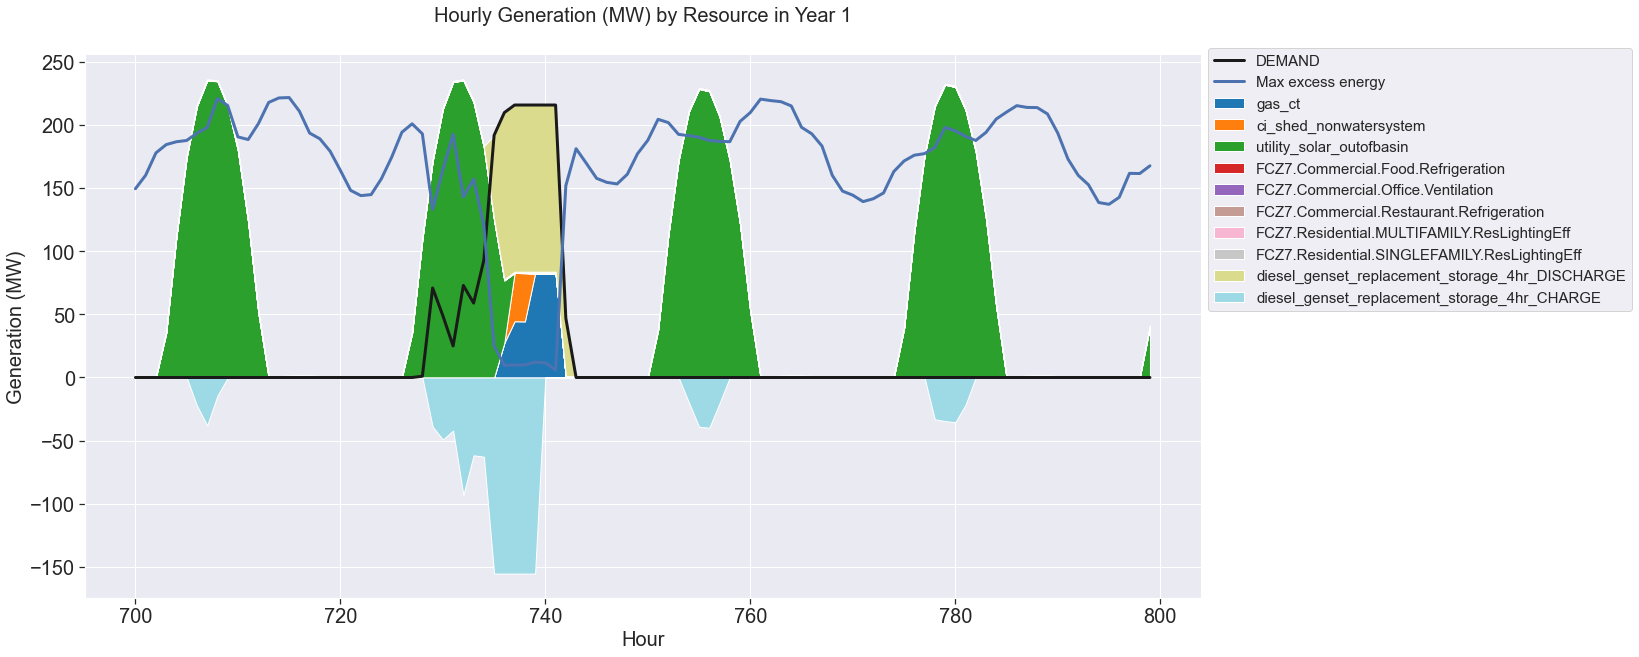

In [63]:
fig, ax = plt.subplots()

#Plot generation lines for each resource as stacked area chart.
lst = list(resource_gen_dict.values())
lines = [item[start_hour:end_hour] for item in lst]
labels = list(resource_gen_dict.keys())

if resource_charge_dict.keys():
    lst_neg = list(resource_charge_dict.values())
    lines_neg = [item[start_hour:end_hour] for item in lst_neg]
    labels_neg = list(resource_charge_dict.keys())

cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1.0, (len(lines))))
if resource_charge_dict.keys():
    colors = cmap(np.linspace(0, 1.0, (len(lines)+len(lines_neg))))

plt.stackplot(profiles.index[start_hour:end_hour], lines, labels = labels, colors = colors[0:len(lines)+1])

if resource_charge_dict.keys():
    plt.stackplot(profiles.index[start_hour:end_hour], lines_neg, labels = labels_neg, colors = colors[len(lines):])

#Plot demand.
plt.plot(profiles.index[start_hour:end_hour], demand['load_mw'][start_hour:end_hour], label = 'DEMAND', color = 'k', linewidth = 3)

#Plot max excess energy.
plt.plot(profiles.index[start_hour:end_hour], hourly_max_excess_energy['max_excess_energy (mwh)'][start_hour:end_hour], label = 'Max excess energy', color = 'b', linewidth = 3)


sns.set()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77), fontsize = 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Hour', fontsize = 20)
ax.set_ylabel('Generation (MW)', fontsize = 20)
ax.set_title('Hourly Generation (MW) by Resource in Year '+ str(results_year+1),fontsize = 20).set_position([.5, 1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(20, 10)

#### To plot specific resources, run the following cell to get a list of resource names. Then choose certain resources and put them in quotations in the subsequent cell.

In [49]:
print(list(resource_gen_dict.keys()))

['gas_ct', 'ci_shed_nonwatersystem', 'utility_solar_outofbasin', 'FCZ7.Commercial.Food.Refrigeration', 'FCZ7.Commercial.Office.Ventilation', 'FCZ7.Commercial.Restaurant.Refrigeration', 'FCZ7.Residential.MULTIFAMILY.ResLightingEff', 'FCZ7.Residential.SINGLEFAMILY.ResLightingEff', 'diesel_genset_replacement_storage_4hr_DISCHARGE']


In [50]:
#Change resource name in quotations 
selected_resources = ['diesel_genset_replacement_storage_4hr_DISCHARGE', 'diesel_genset_replacement_storage_4hr_CHARGE']

#### Choose a build year, start hour, and end hour to display results.

In [59]:
#Choose a build year to display results, index starts at 0.
results_year = 0

#Choose the hour range to display results, index starts at 0.
start_hour = 700
end_hour = 800

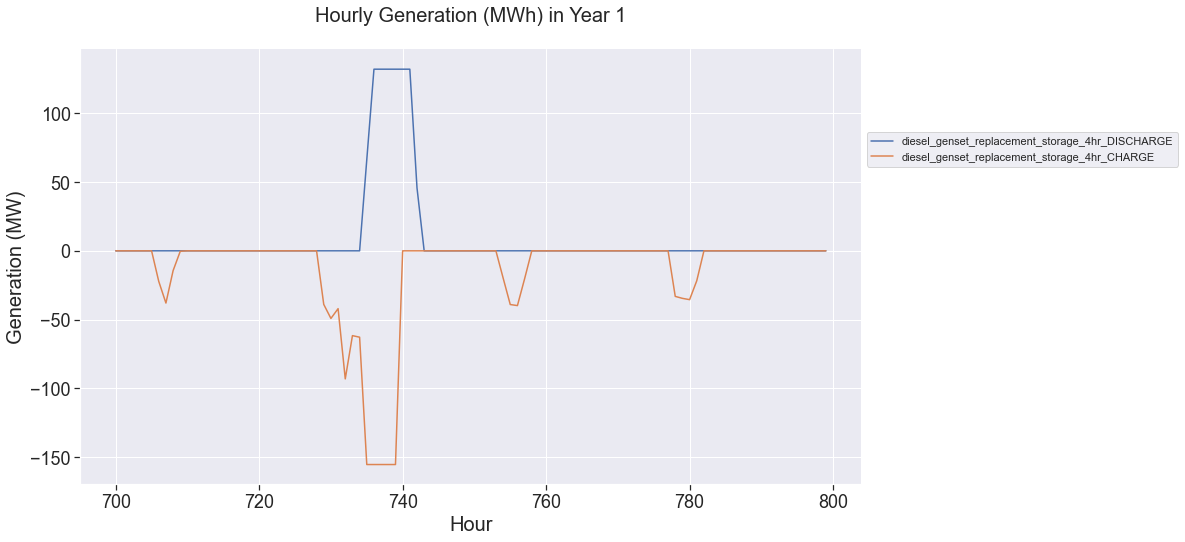

In [60]:
fig, ax = plt.subplots()

for resource in selected_resources:
    if resource in list(resource_gen_dict.keys()):
        gen_line = resource_gen_dict[resource]
        plt.plot(profiles.index[start_hour:end_hour], gen_line[start_hour:end_hour], label = str(resource))

    if resource in list(resource_charge_dict.keys()):
        gen_line = resource_charge_dict[resource]
        plt.plot(profiles.index[start_hour:end_hour], gen_line[start_hour:end_hour], label = str(resource)) 
    
#Plot demand.
#plt.plot(demand.index[start_hour:end_hour], demand['load_mw'], label = 'DEMAND', color = 'k')

sns.set()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Hour', fontsize = 20)
ax.set_ylabel('Generation (MW)', fontsize = 20)
ax.set_title('Hourly Generation (MWh) in Year '+ str(results_year+1),fontsize = 20).set_position([.5, 1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fig.set_size_inches(14, 8)

#### To sweep through values of a particular parameter, follow the format below. Set the chosen parameter equal to the 'parameter_value' when running the linear program. Then run the cell and wait for the solver to find the optimal solution for each parameter value.

In [28]:
runs = {}

#Change the values in parentheses to starting value, ending value, interval between runs.
for parameter_value in np.arange(0, 1500, 500):
    print(parameter_value)
    
    #Set the chosen parameter equal to 'parameter_value'
    lp = harboropt_lp_storage_buildyear_emissions.LinearProgram(storage_resilience_incentive_per_kwh = parameter_value)
    lp.solve()
    runs[parameter_value] = lp 

0
Solver found optimal solution.
500
Solver found optimal solution.
1000
Solver found optimal solution.


#### Follow the format below to plot the results. In the following example, resilient storage capacity is plotted as a function of the resilient storage incentive.

In [29]:
#Create list of the parameter values looped through above. This will become the x-axis in the figure below.
parameter_values = []

#Create list to hold output values for the dependent variable. This will beomce the y-axis in the figure below.
y_values = []

#Loop through the optimization results, adding the x-values and y-values to the lists above.
for key in runs:
    parameter_values.append(key)
    
    #In this case, the y-value is the storage capacity solution value in the chosen results year. For non-storage resource capacity solution values, use "runs[key].capacity_vars" instead of "runs[key].storage_capacity_vars"
    y_value = runs[key].storage_capacity_vars['resilient_standalone_storage_4hr'][results_year].solution_value()
    y_values.append(y_value)

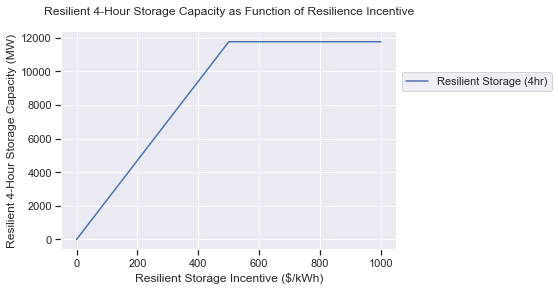

In [30]:
#Change labels to reflect variables graphed.

fig, ax = plt.subplots()

plt.plot(parameter_values, y_values, label = 'Resilient Storage (4hr)') 

sns.set()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Resilient Storage Incentive ($/kWh)')
ax.set_ylabel('Resilient 4-Hour Storage Capacity (MW)')
ax.set_title('Resilient 4-Hour Storage Capacity as Function of Resilience Incentive').set_position([.5, 1.05])

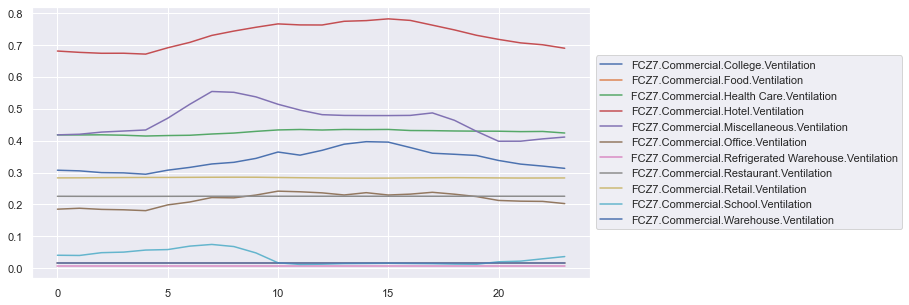

In [115]:
profiles = pd.read_csv('data/gen_profiles.csv')
enduse = 'Ventilation'
enduse_cols = [col for col in profiles.columns if enduse in col]
profiles = profiles[:24][enduse_cols]

profiles.plot.line(figsize=(10,5))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


In [ ]:
lcoe_per_mwh_by_resource = {}
        
for resource in self.capacity_vars:

    lcoe_per_mwh_by_resource[resource]={}

    for build_year in range(self.build_years):

        resource_inds = self.resource_costs['resource']==resource
        cost_year = self.build_start_year + build_year

        capex = self.lcoe_dict[build_year][resource]['capex']
        fixed_extrapolated = self.lcoe_dict[build_year][resource]['fixed_extrapolated']

        #Get range of hours where demand is met in order to index correctly into the list of generation variables.
        demand_year = self.build_years-1
        demand_start_hour = (self.build_years-1)*8760
        demand_end_hour = (self.build_years-1)*8760 + 8760

        #For dispatchable resources, calculate extrapolated variable cost and annual generation per mw of capacity.
        if resource in self.disp.index:

            #Calculated extrapolated variable cost and add to lcoe dictionary. Excludes health impacts of monetized emissions.
            if 'gas' in resource:
                variable_om_inds = self.resource_costs['cost_type']=='variable_per_mwh'
                variable_fuel_cost_inds = self.resource_costs['cost_type']=='fuel_costs_per_mmbtu'
                heat_rate_inds = self.resource_costs['cost_type']=='heat_rate_mmbtu_per_mwh'

                variable_om_cost = self.resource_costs.loc[variable_om_inds & resource_inds,str(cost_year)].item() 
                variable_fuel_cost = self.resource_costs.loc[variable_fuel_cost_inds & resource_inds, str(cost_year)].item()
                variable_heat_rate = self.resource_costs.loc[heat_rate_inds & resource_inds, str(cost_year)].item()

                variable_cost = variable_om_cost + (variable_fuel_cost*variable_heat_rate)# + resource_monetized_emissions

            else:
                variable_cost_inds = self.resource_costs['cost_type']=='variable_per_mwh'
                variable_cost = self.resource_costs.loc[variable_cost_inds & resource_inds,str(cost_year)].item()#+ resource_monetized_emissions

            variable_cost_extrapolated = variable_cost * self.discounting_factor[build_year]

            self.lcoe_dict[build_year][resource]['variable_extrapolated'] = variable_cost_extrapolated

            summed_gen = 0
            #Currently sums generation in the year in which demand must be met with supply (the last build year).
            for i_gen in self.disp_gen[str(resource)][demand_start_hour:demand_end_hour]:
                summed_gen += i_gen.solution_value()

            capacity_cumulative = self.capacity_vars[resource][0:self.build_years+1]
            capacity_total = 0
            for i, var in enumerate(capacity_cumulative):
                capacity_total += var.solution_value()

            if capacity_total >0:
                mwh_per_mw = summed_gen / capacity_total
                self.lcoe_dict[build_year][resource]['annual_generation_per_mw'] = mwh_per_mw
            else:
                print(resource,': Resource is not selected in optimization solution. Cannot calculate LCOE because annual generation is N/A.')

        elif resource in self.nondisp.index:

            profile_max = max(profiles[resource])
            summed_gen = sum(profiles[resource] / profile_max)

            #Add variable costs extrapolated over portfolio timespan to lcoe dictionary.
            self.lcoe_dict[year][resource]['variable_extrapolated']=self.resource_costs.loc[variable_cost_inds & resource_inds, str(cost_year)].item() * summed_gen * self.discounting_factor[build_year]

            #Add annual mwh generated per mw capacity to lcoe dictionary.
            self.lcoe_dict[year][resource]['annual_generation_per_mw']=summed_gen

            variable_cost_extrapolated = self.lcoe_dict[build_year][resource]['variable_extrapolated']
            mwh_per_mw = self.lcoe_dict[build_year][resource]['annual_generation_per_mw']


        variable_costs = variable_cost_extrapolated * mwh_per_mw
        lcoe_per_mw = capex + fixed_extrapolated + variable_costs
        lcoe_per_mwh = lcoe_per_mw / (mwh_per_mw*self.timespan)

        lcoe_per_mwh_by_resource[resource][build_year] = lcoe_per_mwh
        